<a href="https://colab.research.google.com/github/AndreiLesi/Spark-DE/blob/master/Apache_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q pyspark

     |████████████████████████████████| 204.7MB 76kB/s 
     |████████████████████████████████| 204kB 37.3MB/s 


In [ ]:
#from google.colab import files
## Load Players.txt 
#uploaded = files.upload()

Saving Churn.csv to Churn.csv


# Initialize Spark

In [ ]:
import pyspark
import random
from pyspark.sql import SparkSession
from pyspark.sql.types import *

spark = SparkSession.builder.appName("PySpark").getOrCreate()
sc = pyspark.SparkContext.getOrCreate()


# RDD Basics

In [ ]:
# Create RDD from External Data
rdd = sc.textFile('Players.txt')
# Create RDD from Array
rdd2 = sc.parallelize(range(1,5),2)
rdd3 = sc.parallelize([('a',7),('a',2),('b',2)])
# Basic Infromation
print("Number of Elements: ", rdd2.count())
rdd2.countByValue()
print("Sum of all Elements: ",rdd2.sum())
print("RDD is empty :" ,rdd2.isEmpty())

# Summary
print("RDD Summary: ",rdd2.stats())

# Functions
# Basics: collect(), take(N), first(), top(n)
# Map returns list of lists
print("Map: \n", rdd.map(lambda x: x.split(",")).collect())
# flatMap returns only ONE list
print("FlatMap: \n", rdd.flatMap(lambda x: x.split(",")).collect())
# Filtering
print("Filtering: \n", rdd3.filter(lambda x: "a" in x).collect())
# Reducing 
# Reduce by Key merges values for EVERY key, here the 'a' key appears twice 
# the resulting value is therefore the merged(added) values
print("Reducing by Key: \n", rdd3.reduceByKey(lambda x, y: x + y).collect())
# Basic Reduce merges all keys
print("Reducing: \n", rdd3.reduce(lambda x, y: x + y))
# Grouping by:
# Group by function: here based on the first starting literal
rdd_names = sc.parallelize(["John", "Jimmy", "Tina", "Thomas", "James", "Cory"])
print("Group by function: \n", 
      rdd_names.groupBy(lambda x: x[0]).mapValues(list).collect())
print("Group By Key: \n", rdd3.groupByKey().mapValues(list).collect())
# Aggregating:
# Creaate two functions, first one tracks the sum, the second one the length
zeroVals = (0,0) # == (sum, length)
seqOp = (lambda result,elem: (result[0] + elem, result[1] + 1))
combOp = (lambda loc_res1,loc_res2: (loc_res1[0] + loc_res2[0],
          loc_res1[1] + loc_res2[1]))
# Aggregate result is sum 1+2+3+4 = 10 and length = 4
print("Aggregate: \n", rdd2.aggregate(zeroVals, seqOp, combOp))
# Sorting:
print("Sort by (here 2nd tuple element): \n", rdd3.sortBy(lambda x: x[1]).collect())
print("Sort by Key: \n", rdd3.sortByKey().collect())


In [ ]:
rdd3.sortBy(lambda x: x[1]).collect()

In [ ]:
x.groupBy(lambda x: x[0]).mapValues(list).collect()

# Data Frame Basics

In [ ]:
# Read Data with structure to DataFrame
schema = StructType([StructField('Name', StringType(), True),
                     StructField('Nationality', StringType(), True),
                     StructField('Rating', IntegerType(), True),
                     StructField('Club', StringType(), True),
                     StructField('Skills', IntegerType(), True)])
df = spark.read.option("header",True).schema(schema).csv("Players.txt")
# Infer structure:
df = spark.read.csv("Players.txt", inferSchema = True, header = True)

# Insspect Data:
df.printSchema()
df.show()
df.count()


# Churn Analysis

## Load Data

In [ ]:
# Do not forget to run Initialize Spark at the beginning of this document !
from pyspark.sql.functions import isnan, when, count, col
import pandas as pd
from pyspark import SparkFiles

In [ ]:
# Goal: Predict if a customer will churn/cancel subscription or not based on a 
# number of parameters
# Read Dataset
url = "https://raw.githubusercontent.com/treselle-systems/customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv"

spark.sparkContext.addFile(url)

df = spark.read.option("inferSchema", True) \
    .option("header", True) \
    .option("nanValue", " ") \
    .option("nullValue", " ") \
    .csv("file://"+SparkFiles.get("WA_Fn-UseC_-Telco-Customer-Churn.csv"))

In [ ]:
# Dataframe Bassic Information
df.printSchema()
df.show(10)
print("Number of Entries: ",df.count())

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)

+----------+------+-------------+-------+----------+------+------------+---------

## Analyze Data

In [ ]:
# Check if Null Values exist
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# ==> In TotalCharges, 11 Rows are None, we will replace those later on

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

In [ ]:
# Analyze categorical columns -> use df.columns to find out which one there is
catColumns = ["gender", "SeniorCitizen", 'Partner', 'Dependents', 'PhoneService',
          'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
          'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
          'Contract', 'PaperlessBilling', 'PaymentMethod']

# See if dataset is balanced or not -> here unbalanced
df.groupBy("Churn").count().show()

# Note to print information use the inbuild spark commands as follows:
# df.select("gender","churn").groupBy("gender","churn").count().show()
# For a pivot table, convert to pandas dataframe and unse pd.pivot_table
for col in catColumns:
  df_pd = df.select(col,"churn").groupBy(col,"churn").count().toPandas()
  print(pd.pivot_table(df_pd, index = col, columns = "churn"), "\n\n")

# We can see i.e:
#   - gender makes no difference
#   - Higher churn among seniors
#   - Higher churn for fiber optic users or those without online security
#   - Higher churn rate if paperless billing
# etc.

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+

       count     
churn     No  Yes
gender           
Female  2549  939
Male    2625  930 


              count      
churn            No   Yes
SeniorCitizen            
0              4508  1393
1               666   476 


        count      
churn      No   Yes
Partner            
No       2441  1200
Yes      2733   669 


           count      
churn         No   Yes
Dependents            
No          3390  1543
Yes         1784   326 


             count      
churn           No   Yes
PhoneService            
No             512   170
Yes           4662  1699 


                 count     
churn               No  Yes
MultipleLines              
No                2541  849
No phone service   512  170
Yes               2121  850 


                count      
churn              No   Yes
InternetService            
DSL              1962   459
Fiber optic      1799  1297
No               1413   113 


In [ ]:
# Sample more in-depth statistics for the categorical columns

df.stat.crosstab("SeniorCitizen", "InternetService").show()
# We see that senior citizen mostly have Fiber Optic, while non-seniors 
# its mostly DSL and Fiber

df.stat.freqItems(catColumns, 0.6).collect()

+-----------------------------+----+-----------+----+
|SeniorCitizen_InternetService| DSL|Fiber optic|  No|
+-----------------------------+----+-----------+----+
|                            1| 259|        831|  52|
|                            0|2162|       2265|1474|
+-----------------------------+----+-----------+----+



[Row(gender_freqItems=['Male'], SeniorCitizen_freqItems=[0], Partner_freqItems=['No'], Dependents_freqItems=['No'], PhoneService_freqItems=['Yes'], MultipleLines_freqItems=['Yes'], InternetService_freqItems=['Fiber optic'], OnlineSecurity_freqItems=['No'], OnlineBackup_freqItems=['Yes'], DeviceProtection_freqItems=['No'], TechSupport_freqItems=['No'], StreamingTV_freqItems=['Yes'], StreamingMovies_freqItems=['No'], Contract_freqItems=['Month-to-month'], PaperlessBilling_freqItems=['Yes'], PaymentMethod_freqItems=['Bank transfer (automatic)'])]

+-------+------------------+------------------+------------------+
|summary|            tenure|      TotalCharges|    MonthlyCharges|
+-------+------------------+------------------+------------------+
|  count|              7043|              7032|              7043|
|   mean| 32.37114865824223|2283.3004408418697| 64.76169246059922|
| stddev|24.559481023094442| 2266.771361883145|30.090047097678482|
|    min|                 0|              18.8|             18.25|
|    max|                72|            8684.8|            118.75|
+-------+------------------+------------------+------------------+



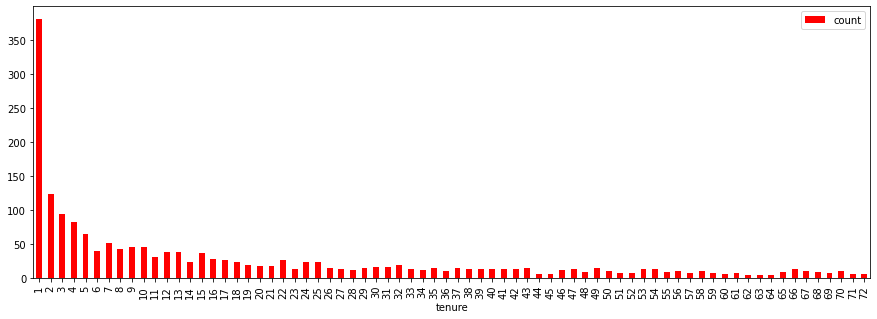

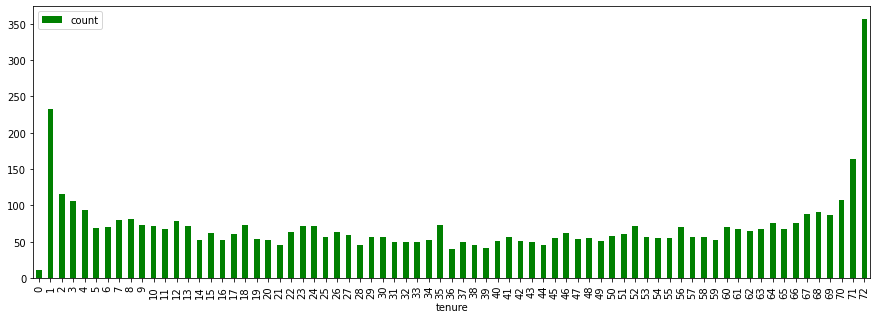

In [ ]:
# Analyze the numeric columns:
df.select("tenure", "TotalCharges", "MonthlyCharges").describe().show()

pdf_df = df.select("tenure", "churn").groupBy("tenure","churn").count()\
                                     .sort("tenure","churn").toPandas()
pdf_df[pdf_df["churn"] == "Yes"].plot.bar(x = "tenure", y = "count", 
                                          figsize = (15,5), color = "r")
pdf_df[pdf_df["churn"] == "No"].plot.bar(x = "tenure", y = "count", 
                                         figsize = (15,5), color = "g")

# We can see that the churn = yes rate drops with increasing tenure
# and subsequently that the churn = no rate increases with incr. tenure

## Create and run the pre-processing pipeline

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,\
                               Imputer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
# Split data into train and test, with a seed of 24 -> ensures same split
(train_data, test_data) = df.randomSplit([0.7, 0.3], 24)
print("Records for trainig: " + str(train_data.count()))
print("Records for evaluation: " + str(test_data.count()))

Records for trainig: 4942
Records for evaluation: 2101


In [ ]:
# Convert Categorical coloums into number using a string encoder and OHE
stages = []

for category in catColumns:
  stringIndexer = StringIndexer(inputCol = category, 
                                outputCol = category + "Index")
  OHE = OneHotEncoder(inputCol= stringIndexer.getOutputCol(), 
                      outputCol = category + "CatVec")
  stages += [stringIndexer, OHE]


In [ ]:
# Fix missing input -> as we saw there are some entries missing in TotalCharges.
# These inputs can be estimated using Linear regerssion -> use Imputer here
imputer = Imputer(inputCol= "TotalCharges", outputCol = "out_TotalCharges")
stages += [imputer]

In [ ]:
# Finally convert label -> churn YES/NO to 0/1 using a string indexer
label_Idx = StringIndexer(inputCol = "Churn", outputCol = "label")
stages += [label_Idx]

In [ ]:
# Extra Feature Engineering Step: We see that tenure decreases linearly

In [ ]:
# create feature Vector using VectorAssembler
numericCols = ["tenure", "out_TotalCharges", "MonthlyCharges"]
assembleInputs = [c + "CatVec" for c in catColumns] + numericCols
assembler = VectorAssembler(inputCols = assembleInputs, outputCol = "features")
stages += [assembler]

In [ ]:
# Final Stages summary:
stages

In [ ]:
# Create pipeline and run it on training data
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train_data)

# Transform Training and Test Data -> Append new categorical and num columns
trainprepDF = pipelineModel.transform(train_data)
testprepDF = pipelineModel.transform(test_data)

In [ ]:
# Finally we the data preprocesssing is finished, the end-result is a 30-dim
# features vector and a numerical labels vector necesarry for training the LR
trainprepDF.printSchema()
trainprepDF.show(2)

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)
 |-- genderIndex: double (nullable = false)
 |-- genderCatVec: vector (nullable = 

## Create and Evaluate Model

In [ ]:
# Use a Logistic Regression for predictions. By default the Model expects
# featuresCol = "features" and labelCol = 'label' as is the case here
lr = LogisticRegression(maxIter=10)
lrModel = lr.fit(trainprepDF)
print("Coefficients: " + str(lrModel.coefficients) + "\n")
print("Intercept: " + str(lrModel.intercept))

Coefficients: [0.05946136114803455,-0.29241891064154973,-0.12029323140772484,0.15733491377478798,-0.5903291950636831,-0.2449757617526484,0.03510007573305093,0.5779795861943308,-0.3999502503975028,0.25696011918915906,-0.058915444597799384,0.16961535968254524,0.04610671965750975,0.13197667191371776,0.08707917668230207,0.24769411163428737,-0.046803112501746326,-0.016786756121783906,0.23757532076737087,0.019150561711108422,0.1997524502333138,0.6632134186102209,-0.7888506252519402,0.3041116045409074,0.34998134161622413,-0.06537830272858573,0.04827077773964068,-0.030036577453548527,-8.645363213308834e-05,0.005287719940492509]

Intercept: -1.152745414953537


Accuracy: 0.8093889113719142
FPR: 0.35233467528542006
TPR: 0.8093889113719142
F-Measure: 0.8037008939706497
Precision: 0.8015041615608187
Recall: 0.8093889113719142
AreaUnderRoc: 0.8520341697473033



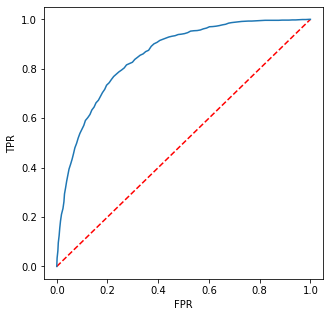

In [ ]:
# Analyze Logistic Regression Results for the Training Dataset
summary = lrModel.summary

accuracy = summary.accuracy
falsePositiveRate = summary.weightedFalsePositiveRate
truePositiveRate = summary.weightedTruePositiveRate
fMeasure = summary.weightedFMeasure()
precision = summary.weightedPrecision
recall = summary.weightedRecall
AreaUnderROC = summary.areaUnderROC

print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-Measure: %s\nPrecision: %s\nRecall: %s\nAreaUnderRoc: %s\n" 
     % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall,AreaUnderROC))

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(summary.roc.select('FPR').collect(),
         summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [ ]:
# Evaluate Logistic Regression using the Testing Dataset
predictions = lrModel.transform(testprepDF)
# The transform method appends 3 new columns to the DF using the LR data, 
# namely RawPred, Prob, Pred. Therefore it is also possible to add the LogReg 
# to the Pipeline!
evaluatorLR = BinaryClassificationEvaluator()
area_under_curve = evaluatorLR.evaluate(predictions)
print("Test Performance: " + str(area_under_curve))

# ?? NOTE/QUESTION: using rawPredictCol = "rawPrediction" the area under curve  
# ?? is entirely different, but why? the evaluator can also take in 

Test Performance: 0.8267006063616201


In [ ]:
# NOTE THIS IS FOR TESTING ONLY. Area under AOC is equal to above if above we
# use BinaryClassificationEvaluator(rawPredictionCol="prediction")
results = predictions.select(["prediction", "label"])

# prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0]), float(i[1])) for i in results_collect]
predictionAndLabels = sc.parallelize(results_list)

metrics = BinaryClassificationMetrics(predictionAndLabels)

print("Area under Precision-Recall: %s" % metrics.areaUnderPR)
print("Area under ROC: %s" % metrics.areaUnderROC)

# areaUnderPR is pretty bad ==> training has overfitted

Area under Precision-Recall: 0.5525483309724795
Area under ROC: 0.7147944647944648


In [ ]:
# Analyzing Test-Dataset:
# We can see that the Test-DS is imbalanced 
test_data.groupBy("churn").count().show()

count = predictions.count()
correct = results.filter(results.prediction == results.label).count()
wrong = results.filter(results.prediction != results.label).count()
tp = results.filter(results.prediction == 1.0).filter(results.prediction == results.label).count()
fp = results.filter(results.prediction == 1.0).filter(results.prediction != results.label).count()
tn= results.filter(results.prediction == 0.0).filter(results.prediction == results.label).count()
fn = results.filter(results.prediction == 0.0).filter(results.prediction != results.label).count()

accuracy = (tp + tn)/count
precision = tp/(tp + fp)
recall = tp/(tp+fn)

print("Correct: %s\nWrong: %s\ntp: %s\nfp: %s\ntn: %s\nfn: %s\naccuracy: %s\nprecision:: %s\nrecall: %s\n"
     % (correct, wrong, tp, fp, tn, fn, accuracy, precision, recall))

# We can see that accuracy is not a good metric because we have an accuracy rate of ~80% but 
# precision and recall are both very low!

+-----+-----+
|churn|count|
+-----+-----+
|   No| 1534|
|  Yes|  567|
+-----+-----+

Correct: 1666
Wrong: 435
tp: 309
fp: 177
tn: 1357
fn: 258
accuracy: 0.7929557353641123
precision:: 0.6358024691358025
recall: 0.544973544973545



## HyperParameter Tuning

In [ ]:
# Perform CrossValidation and look for the best parameter combination
# Create Parameter Grid for Cross Validation
paramGrid = (ParamGridBuilder()
            .addGrid(lr.regParam, [0.01, 0.5, 2.0])
            .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
            .addGrid(lr.maxIter, [5, 10, 15])
            .build())

# Use 5-Fold CrossValidation to test the parameter combinations
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, 
                    evaluator = evaluatorLR)
cvModel = cv.fit(trainprepDF)

In [ ]:
# Evaluate Results with optimal parameters
predictions = cvModel.bestModel.transform(testprepDF)
evaluatorLR.evaluate(predictions)

0.8282487025424852

Accuracy: 0.8087818696883853
FPR: 0.3579783721106941
TPR: 0.8087818696883853
F-Measure: 0.8024789075235855
Precision: 0.8003519080451709
Recall: 0.8087818696883853
AreaUnderRoc: 0.8527074787731468



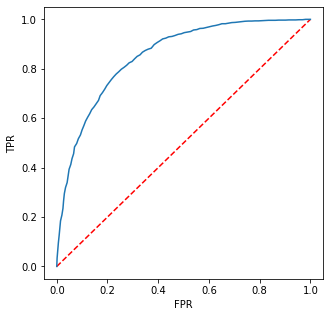

In [ ]:
# Analyze Logistic Regression Results for the Training Dataset
summary = cvModel.bestModel.summary

accuracy = summary.accuracy
falsePositiveRate = summary.weightedFalsePositiveRate
truePositiveRate = summary.weightedTruePositiveRate
fMeasure = summary.weightedFMeasure()
precision = summary.weightedPrecision
recall = summary.weightedRecall
AreaUnderROC = summary.areaUnderROC

print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-Measure: %s\nPrecision: %s\nRecall: %s\nAreaUnderRoc: %s\n" 
     % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall,AreaUnderROC))

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(summary.roc.select('FPR').collect(),
         summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

## Different Classifier

In [ ]:
rf = RandomForestClassifier()

paramGrid = (ParamGridBuilder()
            .addGrid(rf.impurity, ["gini", "entropy"])
            .addGrid(rf.numTrees, [20, 40, 60])
            .addGrid(rf.maxDepth, [5, 10, 15])
            .build())

# Use 5-Fold CrossValidation to test the parameter combinations
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, 
                    evaluator = evaluatorLR)
cvModel = cv.fit(trainprepDF)

In [ ]:
predictions = cvModel.bestModel.transform(testprepDF)
evaluatorLR.evaluate(predictions)

0.8328395291672123

In [ ]:
cvModel.extractParamMap()

In [ ]:
# Analyzing Test-Dataset:
# We can see that the Test-DS is imbalanced 
results = predictions.select("prediction","label")

count = predictions.count()
correct = results.filter(results.prediction == results.label).count()
wrong = results.filter(results.prediction != results.label).count()
tp = results.filter(results.prediction == 1.0).filter(results.prediction == results.label).count()
fp = results.filter(results.prediction == 1.0).filter(results.prediction != results.label).count()
tn= results.filter(results.prediction == 0.0).filter(results.prediction == results.label).count()
fn = results.filter(results.prediction == 0.0).filter(results.prediction != results.label).count()

accuracy = (tp + tn)/count
precision = tp/(tp + fp)
recall = tp/(tp+fn)

print("Correct: %s\nWrong: %s\ntp: %s\nfp: %s\ntn: %s\nfn: %s\naccuracy: %s\nprecision:: %s\nrecall: %s\n"
     % (correct, wrong, tp, fp, tn, fn, accuracy, precision, recall))

# We can see that accuracy is not a good metric because we have an accuracy rate of ~80% but 
# precision and recall are both very low!

NameError: ignored

In [ ]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier()

paramGrid = (ParamGridBuilder()
            .addGrid(gbt.maxIter, [20, 30, 40])
            .build())

# Use 5-Fold CrossValidation to test the parameter combinations
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, 
                    evaluator = evaluatorLR, numFolds = 3, parallelism = 3)
cvModel = cv.fit(trainprepDF)

In [ ]:
predictions = cvModel.bestModel.transform(testprepDF)
evaluatorLR.evaluate(predictions)

0.8305768828367697

In [ ]:
df_pd = df.select("PaymentMethod","churn").groupBy("PaymentMethod","churn").count().toPandas()

In [ ]:
df_pd

,PaymentMethod,churn,count
0,Credit card (automatic),No,1290
1,Bank transfer (automatic),No,1286
2,Mailed check,Yes,308
3,Credit card (automatic),Yes,232
4,Electronic check,No,1294
5,Electronic check,Yes,1071
6,Bank transfer (automatic),Yes,258
7,Mailed check,No,1304


pandas.core.frame.DataFrame

In [ ]:
import pandas as pd
from IPython.display import display, HTML

# Load Data
url = "https://raw.githubusercontent.com/treselle-systems/customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = pd.read_csv(url)

In [ ]:
df2 = df[["PaymentMethod","Churn"]].groupby(["PaymentMethod","Churn"])["Churn"].count().to_frame("count")

In [ ]:
df2

count
PaymentMethod             Churn       
Bank transfer (automatic) No      1286
                          Yes      258
Credit card (automatic)   No      1290
                          Yes      232
Electronic check          No      1294
                          Yes     1071
Mailed check              No      1304
                          Yes      308

,PaymentMethod,Churn,count
0,Bank transfer (automatic),No,1286
1,Bank transfer (automatic),Yes,258
2,Credit card (automatic),No,1290
3,Credit card (automatic),Yes,232
4,Electronic check,No,1294
5,Electronic check,Yes,1071
6,Mailed check,No,1304
7,Mailed check,Yes,308
